# References

Abullaha. Student Dropout Analysis and Prediction Dataset. Kaggle, https://www.kaggle.com/datasets/abdullah0a/student-dropout-analysis-and-prediction-dataset. 

# Appendix A: Code Implementation

This appendix contains the code used to implement the analysis and models described in the report. The code is provided for reproducibility and to allow further exploration of the methodology.

In [1]:
!pip install pandas -q > /dev/null 2>&1
!pip install statsmodels -q > /dev/null 2>&1
!pip install kagglehub -q > /dev/null 2>&1
!pip install matplotlib==3.9.3 -q > /dev/null 2>&1
!pip install sklearn==0.0 -q > /dev/null 2>&1

In [4]:
# Import Data
from IPython.utils.io import capture_output

with capture_output():
    import pandas as pd
    import numpy as np
    import os
    import matplotlib.pyplot as plt
    import statsmodels.formula.api as smf
    from sklearn.model_selection import train_test_split
    from sklearn.tree import DecisionTreeClassifier, plot_tree
    from sklearn.model_selection import GridSearchCV, KFold
    from sklearn.metrics import roc_curve, auc
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import confusion_matrix

In [5]:
student = pd.read_csv("student dropout.csv")

In [6]:
object_features = ['School_Support', 
                   'Family_Support',
                   'Extra_Paid_Class', 
                   'Extra_Curricular_Activities',
                   'Attended_Nursery',
                   'Wants_Higher_Education', 
                   'Internet_Access',                
                   'In_Relationship'] 


for feature in object_features:
    student[feature] = student[feature].apply(lambda x: 1 if x == 'yes' else 0)

In [7]:
#Train-test split 
student_train, student_test = train_test_split(student, test_size=0.3, random_state=142)
student_train.shape, student_test.shape

((454, 34), (195, 34))

# Part 0 Classification via Naive Baseline Model

In [6]:
y_test = student_test['Dropped_Out']
y_base_pred = np.array([student_train['Dropped_Out'].mode()[0]  for _ in range(len(y_test))])
cm = confusion_matrix(y_test, y_base_pred)
print ("Confusion Matrix : \n", cm)
print(cm.ravel())

def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()  # Accuracy
    TPR = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # True Positive Rate (Recall)
    FPR = cm[0, 1] / (cm[0, 1] + cm[0, 0])  # False Positive Rate
    return accuracy, TPR, FPR

base_accuracy, base_TPR, base_FPR = calculate_metrics(y_test, y_base_pred)

results = pd.DataFrame({
    'Model': ['Naive Baseline'],
    'Accuracy': [base_accuracy],
    'TPR': [base_TPR],
    'FPR': [base_FPR]
})

results


Confusion Matrix : 
 [[166   0]
 [ 29   0]]
[166   0  29   0]


,Model,Accuracy,TPR,FPR
0,Naive Baseline,0.851282,0.0,0.0


# Part 1 Classification via Logistic Regression

In [7]:
student_train_1 = student_train.copy()
student_test_1 = student_test.copy()
student_train_1['Dropped_Out'] = student_train_1['Dropped_Out'].apply(lambda x: 1 if x is True else 0)
student_test_1['Dropped_Out'] = student_test_1['Dropped_Out'].apply(lambda x: 1 if x is True else 0)

student_train_1 = pd.get_dummies(student_train_1, columns = ['School', 
                                                             'Gender', 
                                                             'Address', 
                                                             'Family_Size',
                                                             'Parental_Status', 
                                                             'Mother_Job', 
                                                             'Father_Job', 
                                                             'Reason_for_Choosing_School', 
                                                             'Guardian'], drop_first = True)

student_test_1 = pd.get_dummies(student_test_1, columns = ['School', 
                                                           'Gender', 
                                                           'Address', 
                                                           'Family_Size',
                                                           'Parental_Status', 
                                                           'Mother_Job', 
                                                           'Father_Job', 
                                                           'Reason_for_Choosing_School', 
                                                           'Guardian'], drop_first =True)

student_train_1 = student_train_1.applymap(lambda x:int(x) if isinstance(x,bool) else x).drop(columns = ['Final_Grade'])
student_test_1 = student_test_1.applymap(lambda x:int(x) if isinstance(x,bool) else x).drop(columns = ['Final_Grade'])                         

In [8]:
### Remove Final_Grade since it it a linear combination of Grade_1 and Grade_2
formula = ('Dropped_Out ~ Age + Mother_Education + Father_Education + Travel_Time + Study_Time + Number_of_Failures +'
'School_Support + Family_Support + Extra_Paid_Class + Extra_Curricular_Activities + Attended_Nursery +'
'Wants_Higher_Education + Internet_Access + In_Relationship + Family_Relationship + Free_Time + Going_Out +'
'Weekend_Alcohol_Consumption + Weekday_Alcohol_Consumption + Health_Status + Number_of_Absences +'
'Grade_1 + Grade_2 + School_MS + Gender_M + Address_U + Family_Size_LE3 + Parental_Status_T +'
'Mother_Job_health + Mother_Job_other + Mother_Job_services + Mother_Job_teacher + Father_Job_health +'
'Father_Job_other + Father_Job_services + Father_Job_teacher + Reason_for_Choosing_School_home + '
'Reason_for_Choosing_School_other + Reason_for_Choosing_School_reputation + Guardian_mother + Guardian_other'
)

logreg = smf.logit(formula = formula, data = student_train_1).fit()
print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.096022
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:            Dropped_Out   No. Observations:                  454
Model:                          Logit   Df Residuals:                      412
Method:                           MLE   Df Model:                           41
Date:                Thu, 12 Dec 2024   Pseudo R-squ.:                  0.7786
Time:                        06:43:08   Log-Likelihood:                -43.594
converged:                       True   LL-Null:                       -196.87
Covariance Type:            nonrobust   LLR p-value:                 2.377e-42
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                31.9965     

In [9]:
### Remove all features that are not statistically significant -> simpler model
formula = ('Dropped_Out ~ Age +  Grade_1 + Grade_2'
)

logreg = smf.logit(formula = formula, data = student_train_1).fit()
print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.138879
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:            Dropped_Out   No. Observations:                  454
Model:                          Logit   Df Residuals:                      450
Method:                           MLE   Df Model:                            3
Date:                Thu, 12 Dec 2024   Pseudo R-squ.:                  0.6797
Time:                        06:43:08   Log-Likelihood:                -63.051
converged:                       True   LL-Null:                       -196.87
Covariance Type:            nonrobust   LLR p-value:                 1.003e-57
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.9540      4.943      5.251      0.000      16.266      35.642
Age           -0.3965      0

In [10]:
y_test = student_test_1['Dropped_Out']
X_test = student_test_1.drop(columns=['Dropped_Out'])
y_prob = logreg.predict(X_test)
y_log_pred = [1 if y > 0.5 else 0 for y in y_prob]

cm = confusion_matrix(y_test, y_log_pred)
print ("Confusion Matrix : \n", cm)
print(cm.ravel())

# Logistic Regression 
log_accuracy, log_TPR, log_FPR = calculate_metrics(y_test, y_log_pred)

results = pd.DataFrame({
    'Model': ['Naive Baseline','Logistic Regression'],
    'Accuracy': [base_accuracy, log_accuracy],
    'TPR': [base_TPR, log_TPR],
    'FPR': [base_FPR, log_FPR]
})

results

Confusion Matrix : 
 [[164   2]
 [  9  20]]
[164   2   9  20]


,Model,Accuracy,TPR,FPR
0,Naive Baseline,0.851282,0.000000,0.000000
1,Logistic Regression,0.943590,0.689655,0.012048


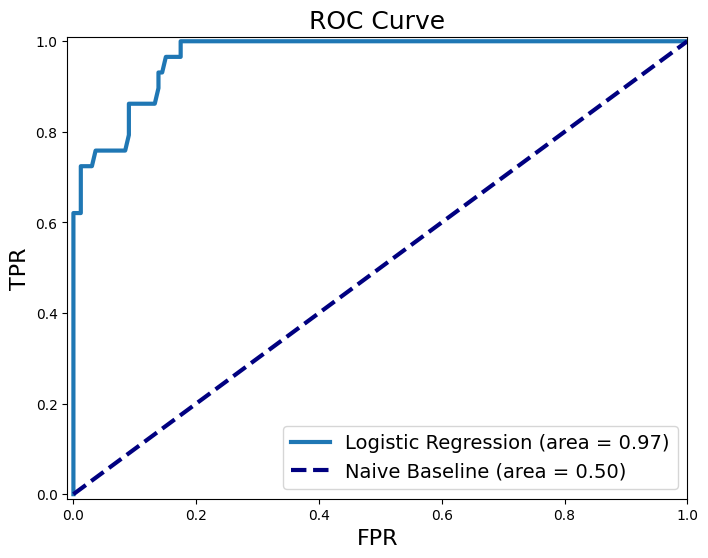

In [11]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Logistic Regression (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=14)
plt.show()

# Part 2 Classification via Classification Tree 

In [12]:
student_train_2 = student_train.copy()
student_test_2 = student_test.copy()
student_train_2['Dropped_Out'] = student_train_2['Dropped_Out'].apply(lambda x: 1 if x is True else 0)
student_test_2['Dropped_Out'] = student_test_2['Dropped_Out'].apply(lambda x: 1 if x is True else 0)

# #Dummuy code categorical variables
student_train_2 = pd.get_dummies(student_train_2, columns = ['School', 
                                                             'Gender', 
                                                             'Address', 
                                                             'Family_Size',
                                                             'Parental_Status', 
                                                             'Mother_Job', 
                                                             'Father_Job', 
                                                             'Reason_for_Choosing_School', 
                                                             'Guardian'], drop_first = True)
                           
student_test_2 = pd.get_dummies(student_test_2, columns = ['School', 
                                                           'Gender', 
                                                           'Address', 
                                                           'Family_Size',
                                                           'Parental_Status', 
                                                           'Mother_Job', 
                                                           'Father_Job', 
                                                           'Reason_for_Choosing_School', 
                                                           'Guardian'], drop_first =True)

student_train_2 = student_train_2.applymap(lambda x:int(x) if isinstance(x,bool) else x).drop(columns = ['Final_Grade'])
student_test_2 = student_test_2.applymap(lambda x:int(x) if isinstance(x,bool) else x).drop(columns = ['Final_Grade'])

In [13]:
# Include all features
X_train = student_train_2.drop(columns = ['Dropped_Out'])
y_train = student_train_2['Dropped_Out']
X_test = student_test_2.drop(columns = ['Dropped_Out'])
y_test = student_test_2['Dropped_Out']

In [14]:
ccp_alpha_values = np.linspace(0, 0.01, 301)
param_grid = {'ccp_alpha': ccp_alpha_values, 
              'random_state':[2024],
              'min_samples_leaf': [5],
              'class_weight': [{0: 1, 1: 5}]
             }
# 'class_weight': [{0: 1, 1: 10}]
ctree = DecisionTreeClassifier()
cv = KFold(n_splits=5,random_state=2024,shuffle=True)
ctree_cv = GridSearchCV(ctree, 
                        param_grid = param_grid,
                        cv=cv, 
                        scoring='recall',
                        verbose=1)
ctree_cv.fit(X_train, y_train)
best_ccp_alpha = ctree_cv.best_params_['ccp_alpha'] 
print(f'Best ccp_alpha: {best_ccp_alpha}')

Fitting 5 folds for each of 301 candidates, totalling 1505 fits
Best ccp_alpha: 0.008400000000000001


In [15]:
plt.figure(figsize=(200,100))
plot_tree(ctree_cv.best_estimator_, filled=True, feature_names=X_train.columns, class_names=['Dropped Out = False', 'Dropped Out = True'], rounded=True) 
plt.show()

In [16]:
y_ctree_pred = ctree_cv.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_ctree_pred )
print ("Confusion Matrix : \n", cm)
print(cm.ravel())

# Classificaion Tree
ctree_accuracy, ctree_TPR, ctree_FPR = calculate_metrics(y_test, y_ctree_pred)

results = pd.DataFrame({
    'Model': ['Naive Baseline','Logistic Regression', 'Classification Tree'],
    'Accuracy': [base_accuracy, log_accuracy, ctree_accuracy],
    'TPR': [base_TPR, log_TPR, ctree_TPR],
    'FPR': [base_FPR, log_FPR, ctree_FPR]
})

results

Confusion Matrix : 
 [[147  19]
 [  5  24]]
[147  19   5  24]


,Model,Accuracy,TPR,FPR
0,Naive Baseline,0.851282,0.000000,0.000000
1,Logistic Regression,0.943590,0.689655,0.012048
2,Classification Tree,0.876923,0.827586,0.114458


# Part 3 Classification via Random Forest

In [17]:
grid_values = {'max_features': np.linspace(1,X_train.shape[1],X_train.shape[1], dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators':[500],
               'random_state': [2024],
               'class_weight': [{0: 1, 1: 5}]}

rf = RandomForestClassifier()
cv = KFold(n_splits=5,random_state=2024,shuffle=True)
rf_cv = GridSearchCV(rf, 
                     param_grid=grid_values, 
                     scoring='recall', 
                     cv=cv,
                     verbose=1)
rf_cv.fit(X_train, y_train)
best_max_features = rf_cv.best_params_['max_features'] 
print(f'Best max_features: {best_max_features}')

Fitting 5 folds for each of 41 candidates, totalling 205 fits
Best max_features: 4


In [18]:
### Show importance score
importance = pd.DataFrame({'Feature' : X_train.columns,
              'Importance score': 100*rf_cv.best_estimator_.feature_importances_}).round(1)
importance = importance.sort_values(by='Importance score', ascending=False)
###importance.head(10)

In [19]:
y_rf_pred = rf_cv.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_rf_pred)
print ("Confusion Matrix : \n", cm)
print(cm.ravel())
rf_accuracy, rf_TPR, rf_FPR = calculate_metrics(y_test, y_rf_pred)

results = pd.DataFrame({
    'Model': ['Naive Baseline','Logistic Regression', 'Classification Tree', 'Random Forest'],
    'Accuracy': [base_accuracy, log_accuracy, ctree_accuracy, rf_accuracy],
    'TPR': [base_TPR, log_TPR, ctree_TPR, rf_TPR],
    'FPR': [base_FPR, log_FPR, ctree_FPR, rf_FPR]
})

results

Confusion Matrix : 
 [[158   8]
 [  6  23]]
[158   8   6  23]


,Model,Accuracy,TPR,FPR
0,Naive Baseline,0.851282,0.000000,0.000000
1,Logistic Regression,0.943590,0.689655,0.012048
2,Classification Tree,0.876923,0.827586,0.114458
3,Random Forest,0.928205,0.793103,0.048193


In [20]:
bs_test = student_test_2

def perform_bootstrap(df): 
    # np.random.seed(random_state)
    bs_df = np.random.choice(df.index, df.shape[0], replace = True)
    bs_df = df.loc[bs_df] #df.loc[[1, 2, .. ,n ]]
    return bs_df

def calculate_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()  # Accuracy
    return accuracy

import time
def bootstrap_metric(data, model, B = 1000):
    accu_lst = []
    tpr_lst = []
    fpr_lst = []
    for i in range(B):
         bs_df = perform_bootstrap(data) # test data 
         y_test = bs_df['Dropped_Out']
         X_test = bs_df.drop(columns = ['Dropped_Out'])
         y_pred = model.predict(X_test)
         if model == logreg:
             y_pred = [1 if y > 0.5 else 0 for y in y_pred]
         accu_lst.append(calculate_metrics(y_test, y_pred)[0])
         tpr_lst.append(calculate_metrics(y_test, y_pred)[1])
         fpr_lst.append(calculate_metrics(y_test, y_pred)[2])
    return accu_lst, tpr_lst, fpr_lst

logreg_bs_metric = bootstrap_metric(bs_test, logreg)
ctree_bs_metric = bootstrap_metric(bs_test, ctree_cv)
rf_bs_metric = bootstrap_metric(bs_test, rf_cv)



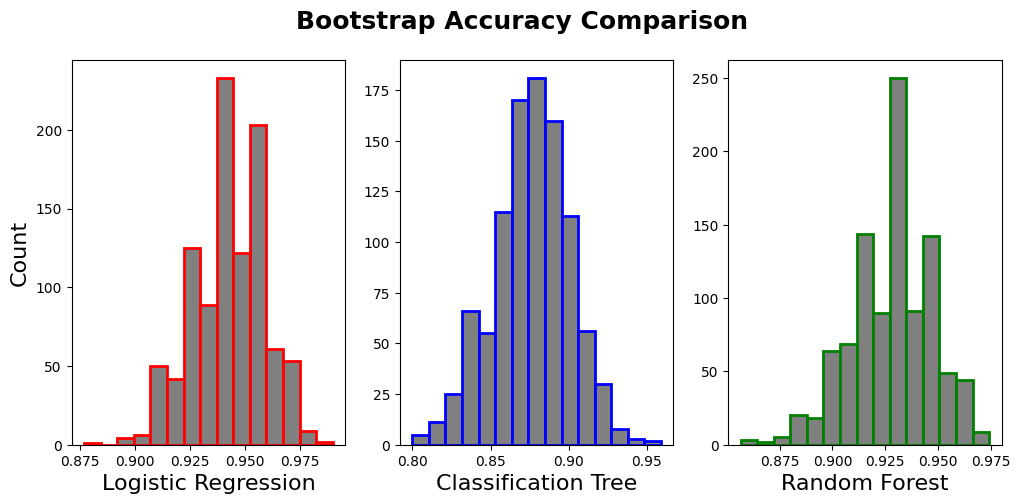

In [21]:
fig, axs = plt.subplots(ncols=3, figsize=(12,5))
fig.suptitle("Bootstrap Accuracy Comparison", fontsize=18, fontweight='bold')
axs[0].set_xlabel('Logistic Regression', fontsize=16)
axs[1].set_xlabel('Classification Tree', fontsize=16)
axs[2].set_xlabel('Random Forest', fontsize=16)
axs[0].set_ylabel('Count', fontsize=16)
axs[0].hist(logreg_bs_metric[0], bins=15, edgecolor='red', linewidth=2,color = "grey")
axs[1].hist(ctree_bs_metric[0], bins=15, edgecolor='blue', linewidth=2,color = "grey")
axs[2].hist(rf_bs_metric[0], bins=15, edgecolor='green', linewidth=2,color = "grey");

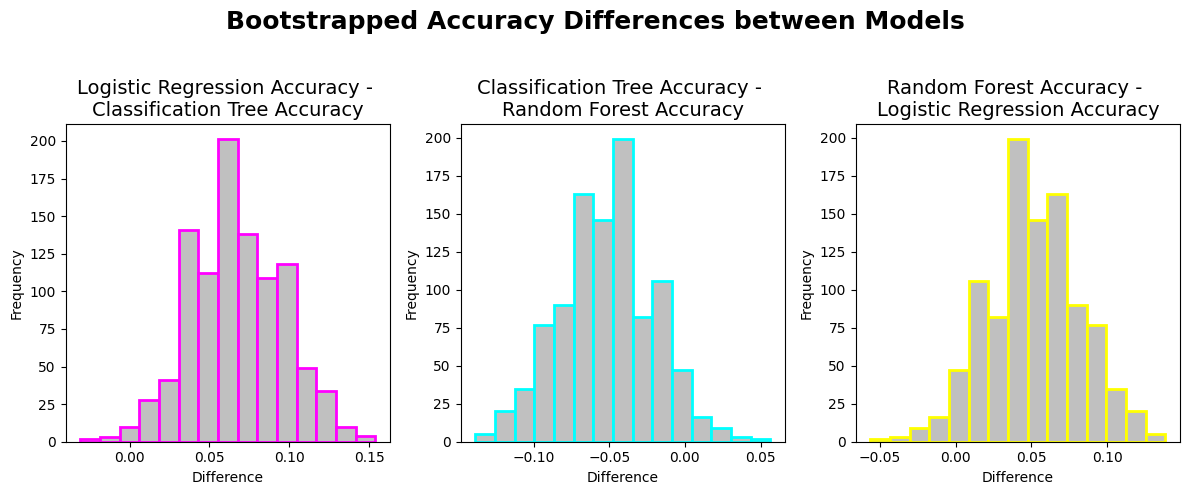

The 95-percent confidence interval of Bootstrapped Logistic Regression Accuracy - Bootstrapped Classification Tree Accuracy is [0.01025641 0.12320513]
The 95-percent confidence interval of Bootstrapped Classification Tree Accuracy - Bootstrapped Random Forest Accuracy is [-0.10782051  0.00512821]
The 95-percent confidence interval of Bootstrapped Random Forest Accuracy - Bootstrapped Logistic Regression Accuracy is [-0.06153846  0.03089744]


In [22]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
fig.suptitle("Bootstrapped Accuracy Differences between Models", fontsize=18, fontweight='bold')

# Logistic Regression vs Classification Tree
axs[0].hist(np.array(logreg_bs_metric[0]) - np.array(ctree_bs_metric[0])  , bins=15, edgecolor='magenta', linewidth=2, color="silver")
axs[0].set_title('Logistic Regression Accuracy - \nClassification Tree Accuracy', fontsize=14)
axs[0].set_xlabel('Difference')
axs[0].set_ylabel('Frequency')

# Classification Tree vs Random Forest
axs[1].hist(np.array(ctree_bs_metric[0]) - np.array(rf_bs_metric[0]), bins=15, edgecolor='cyan', linewidth=2, color="silver")
axs[1].set_title('Classification Tree Accuracy - \nRandom Forest Accuracy', fontsize=14)
axs[1].set_xlabel('Difference')
axs[1].set_ylabel('Frequency')

# Random Forest vs Logistic Regression
axs[2].hist(np.array(rf_bs_metric[0]) - np.array(ctree_bs_metric[0]), bins=15, edgecolor='yellow', linewidth=2, color="silver")
axs[2].set_title('Random Forest Accuracy - \nLogistic Regression Accuracy', fontsize=14)
axs[2].set_xlabel('Difference')
axs[2].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
diff_CI = np.quantile(np.array(logreg_bs_metric[0]) - np.array(ctree_bs_metric[0]),np.array([0.025,0.975]))
print("The 95-percent confidence interval of Bootstrapped Logistic Regression Accuracy - Bootstrapped Classification Tree Accuracy is %s" % diff_CI)
diff_CI = np.quantile(np.array(ctree_bs_metric[0]) - np.array(rf_bs_metric[0]),np.array([0.025,0.975]))
print("The 95-percent confidence interval of Bootstrapped Classification Tree Accuracy - Bootstrapped Random Forest Accuracy is %s" % diff_CI)
diff_CI = np.quantile(np.array(rf_bs_metric[0]) - np.array(logreg_bs_metric[0]),np.array([0.025,0.975]))
print("The 95-percent confidence interval of Bootstrapped Random Forest Accuracy - Bootstrapped Logistic Regression Accuracy is %s" % diff_CI)

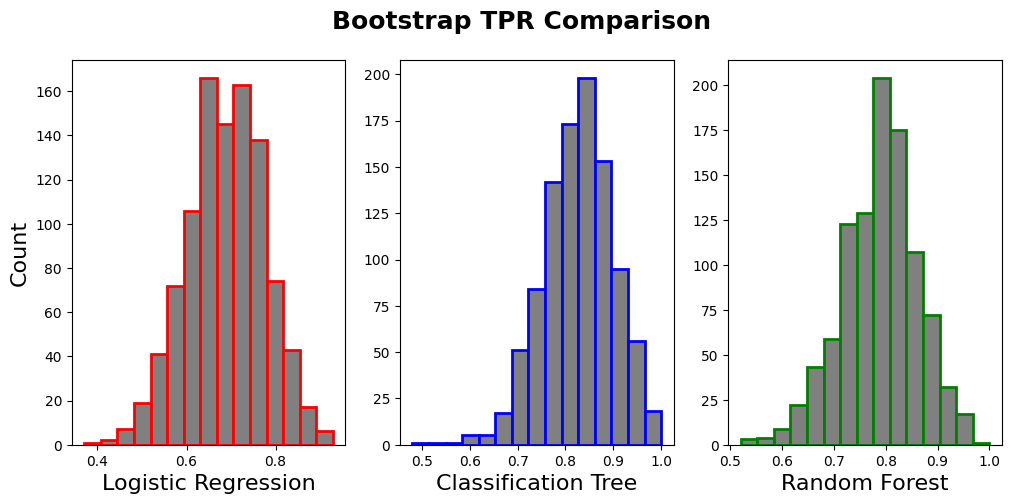

In [23]:
fig, axs = plt.subplots(ncols=3, figsize=(12,5))
fig.suptitle("Bootstrap TPR Comparison", fontsize=18, fontweight='bold')
axs[0].set_xlabel('Logistic Regression', fontsize=16)
axs[1].set_xlabel('Classification Tree', fontsize=16)
axs[2].set_xlabel('Random Forest', fontsize=16)
axs[0].set_ylabel('Count', fontsize=16)
axs[0].hist(logreg_bs_metric[1], bins=15, edgecolor='red', linewidth=2,color = "grey")
axs[1].hist(ctree_bs_metric[1], bins=15, edgecolor='blue', linewidth=2,color = "grey")
axs[2].hist(rf_bs_metric[1], bins=15, edgecolor='green', linewidth=2,color = "grey");

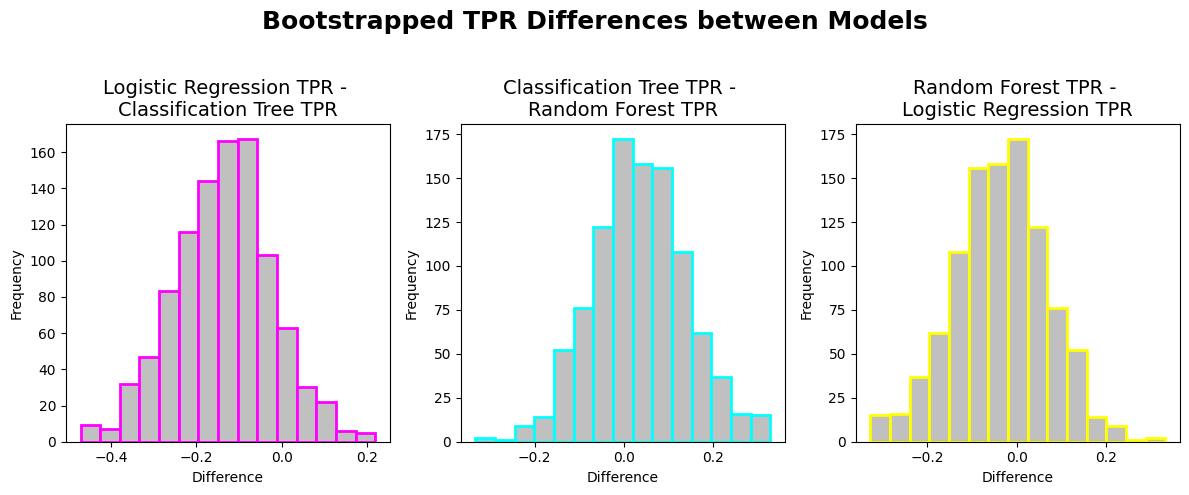

The 95-percent confidence interval of Bootstrapped Logistic Regression TPR - Bootstrapped Classification Tree TPR is [-0.3639323   0.08578282]
The 95-percent confidence interval of Bootstrapped Classification Tree TPR - Bootstrapped Random Forest TPR is [-0.16484177  0.25474537]
The 95-percent confidence interval of Bootstrapped Random Forest TPR - Bootstrapped Logistic Regression TPR is [-0.11080723  0.32778844]


In [24]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
fig.suptitle("Bootstrapped TPR Differences between Models", fontsize=18, fontweight='bold')

# Logistic Regression vs Classification Tree
axs[0].hist(np.array(logreg_bs_metric[1]) - np.array(ctree_bs_metric[1])  , bins=15, edgecolor='magenta', linewidth=2, color="silver")
axs[0].set_title('Logistic Regression TPR - \nClassification Tree TPR', fontsize=14)
axs[0].set_xlabel('Difference')
axs[0].set_ylabel('Frequency')

# Classification Tree vs Random Forest
axs[1].hist(np.array(ctree_bs_metric[1]) - np.array(rf_bs_metric[1]), bins=15, edgecolor='cyan', linewidth=2, color="silver")
axs[1].set_title('Classification Tree TPR - \nRandom Forest TPR', fontsize=14)
axs[1].set_xlabel('Difference')
axs[1].set_ylabel('Frequency')

# Random Forest vs Logistic Regression
axs[2].hist(np.array(rf_bs_metric[1]) - np.array(ctree_bs_metric[1]), bins=15, edgecolor='yellow', linewidth=2, color="silver")
axs[2].set_title('Random Forest TPR - \nLogistic Regression TPR', fontsize=14)
axs[2].set_xlabel('Difference')
axs[2].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
diff_CI = np.quantile(np.array(logreg_bs_metric[1]) - np.array(ctree_bs_metric[1]),np.array([0.025,0.975]))
print("The 95-percent confidence interval of Bootstrapped Logistic Regression TPR - Bootstrapped Classification Tree TPR is %s" % diff_CI)
diff_CI = np.quantile(np.array(ctree_bs_metric[1]) - np.array(rf_bs_metric[1]),np.array([0.025,0.975]))
print("The 95-percent confidence interval of Bootstrapped Classification Tree TPR - Bootstrapped Random Forest TPR is %s" % diff_CI)
diff_CI = np.quantile(np.array(rf_bs_metric[1]) - np.array(logreg_bs_metric[1]),np.array([0.025,0.975]))
print("The 95-percent confidence interval of Bootstrapped Random Forest TPR - Bootstrapped Logistic Regression TPR is %s" % diff_CI)

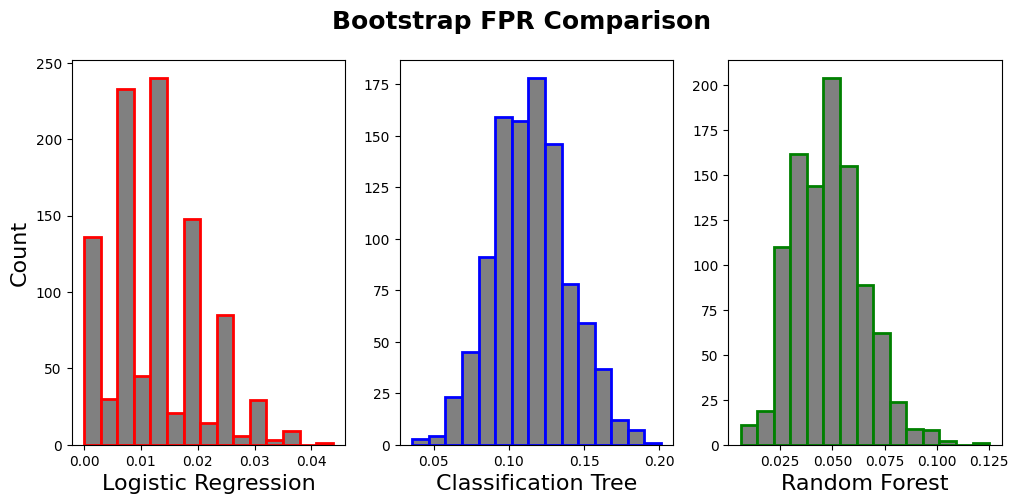

In [25]:
fig, axs = plt.subplots(ncols=3, figsize=(12,5))
fig.suptitle("Bootstrap FPR Comparison", fontsize=18, fontweight='bold')
axs[0].set_xlabel('Logistic Regression', fontsize=16)
axs[1].set_xlabel('Classification Tree', fontsize=16)
axs[2].set_xlabel('Random Forest', fontsize=16)
axs[0].set_ylabel('Count', fontsize=16)
axs[0].hist(logreg_bs_metric[2], bins=15, edgecolor='red', linewidth=2,color = "grey")
axs[1].hist(ctree_bs_metric[2], bins=15, edgecolor='blue', linewidth=2,color = "grey")
axs[2].hist(rf_bs_metric[2], bins=15, edgecolor='green', linewidth=2,color = "grey");

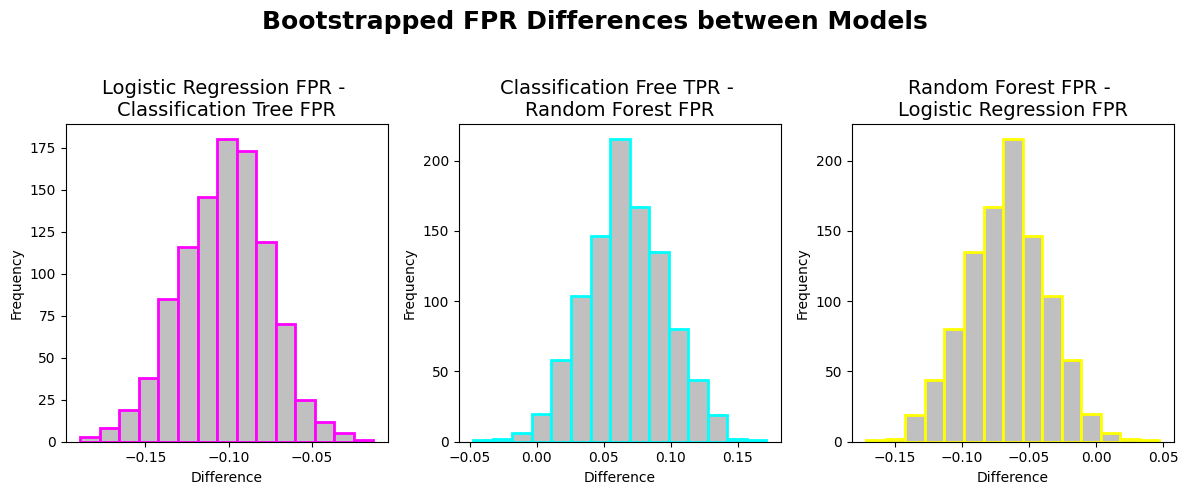

The 95-percent confidence interval of Bootstrapped Logistic Regression FPR - Bootstrapped Classification Tree FPR is [-0.15669952 -0.05319965]
The 95-percent confidence interval of Bootstrapped Classification Tree FPR - Bootstrapped Random Forest FPR is [0.00913638 0.12497264]
The 95-percent confidence interval of Bootstrapped Random Forest FPR - Bootstrapped Logistic Regression FPR is [0.00031599 0.07486924]


In [26]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
fig.suptitle("Bootstrapped FPR Differences between Models", fontsize=18, fontweight='bold')

# Logistic Regression vs Classification Tree
axs[0].hist(np.array(logreg_bs_metric[2]) - np.array(ctree_bs_metric[2])  , bins=15, edgecolor='magenta', linewidth=2, color="silver")
axs[0].set_title('Logistic Regression FPR - \nClassification Tree FPR', fontsize=14)
axs[0].set_xlabel('Difference')
axs[0].set_ylabel('Frequency')

# Classification Tree vs Random Forest
axs[1].hist(np.array(ctree_bs_metric[2]) - np.array(rf_bs_metric[2]), bins=15, edgecolor='cyan', linewidth=2, color="silver")
axs[1].set_title('Classification Free TPR - \nRandom Forest FPR', fontsize=14)
axs[1].set_xlabel('Difference')
axs[1].set_ylabel('Frequency')

# Random Forest vs Logistic Regression
axs[2].hist(np.array(rf_bs_metric[2]) - np.array(ctree_bs_metric[2]), bins=15, edgecolor='yellow', linewidth=2, color="silver")
axs[2].set_title('Random Forest FPR - \nLogistic Regression FPR', fontsize=14)
axs[2].set_xlabel('Difference')
axs[2].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
diff_CI = np.quantile(np.array(logreg_bs_metric[2]) - np.array(ctree_bs_metric[2]),np.array([0.025,0.975]))
print("The 95-percent confidence interval of Bootstrapped Logistic Regression FPR - Bootstrapped Classification Tree FPR is %s" % diff_CI)
diff_CI = np.quantile(np.array(ctree_bs_metric[2]) - np.array(rf_bs_metric[2]),np.array([0.025,0.975]))
print("The 95-percent confidence interval of Bootstrapped Classification Tree FPR - Bootstrapped Random Forest FPR is %s" % diff_CI)
diff_CI = np.quantile(np.array(rf_bs_metric[2]) - np.array(logreg_bs_metric[2]),np.array([0.025,0.975]))
print("The 95-percent confidence interval of Bootstrapped Random Forest FPR - Bootstrapped Logistic Regression FPR is %s" % diff_CI)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=18da8865-0832-4c9d-a299-872be6379c01' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>